In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Bert_Lime/SNLI/

/content/drive/MyDrive/Bert_Lime/SNLI


In [3]:
!pip install transformers
!pip install seqeval datasets allennlp
!pip install flax
!pip install sentencepiece
!pip install nltk
!pip install gensim

In [4]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import Snli
import os

In [5]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [6]:
ac_dict = {"neutral" : 1, "entailment" : 0, "contradiction" : 2}

In [7]:
import os
from operator import itemgetter    
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

# from keras import models, regularizers, layers, optimizers, losses, metrics
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from keras.layers import LayerNormalization
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [8]:
import torch

In [9]:
print(torch.cuda.is_available())

True


In [10]:
print(len(ac_dict))

3


In [11]:
model_version = 'bert-base-cased'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
import torch.nn as nn
import torch

In [13]:
from huggingface_hub import create_repo

In [14]:

from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(model_version,
                                          bos_token = "[CLS]",
                                          eos_token = "[SEP]")
transformer_model = AutoModel.from_pretrained(model_version, output_attentions = True).to(device)
linear_layer = nn.Linear(transformer_model.config.hidden_size,
                         len(ac_dict)).to(device)
cross_entropy_layer = nn.CrossEntropyLoss()
normalizing_layer = nn.Softmax(dim = 1)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# # del transformer_model
# del optimizer

In [15]:
print(transformer_model.config.hidden_size)

768


In [16]:
device

device(type='cuda', index=0)

In [17]:
from tqdm import tqdm

In [18]:
from typing import List, Tuple

In [19]:
def pad_batch(elems: List[List[int]], pad_token_id: int) -> List[List[int]]:
    """Pads all lists in elems to the maximum list length of any list in 
    elems. Pads with pad_token_id.
    """
    max_len = max([len(elem) for elem in elems])
    return [elem+[pad_token_id]*(max_len-len(elem)) for elem in elems]

def load_dataset(tokenizer):
  train, test = tfds.as_numpy(tfds.load("Snli", split=['train', 'test']))

  parts = []

  new_train_data = []
  train_labels = []
  cnt = 0
  for tokenized_text in tqdm(train):
    # cnt += 1
    # if(cnt >= 10000):
    #   break
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_train_data.append(new_encoded_text)
    train_labels.append(tokenized_text["label"])
  
  new_test_data = []
  test_labels = []
  for tokenized_text in tqdm(test):
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_test_data.append(new_encoded_text)
    test_labels.append(tokenized_text["label"])


  return (new_train_data, train_labels), (new_test_data, test_labels)

def generator(dataset_data, dataset_label, max_len = 512, batch_size = 16):
  i = 0
  tokenized_threads, labels = [], []
  while i<len(dataset_data):
    tokenized_threads.append(dataset_data[i][:max_len])
    labels.append(dataset_label[i])
    i += 1
        
    if i%batch_size==0:
      yield (pad_batch(tokenized_threads, tokenizer.pad_token_id), 
                  labels)
      tokenized_threads, labels = [], []

In [20]:
from itertools import chain

import torch.optim as optim

optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                      linear_layer.parameters()),
                       lr = 2e-5)

In [21]:
def train(dataset_data, dataset_label, batch_size):
    global values_weight, values_bias;
    accumulate_over = 32
    
    optimizer.zero_grad()
    print("Training")
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label,  batch_size = batch_size)):
        
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        labels = torch.tensor(labels, device=device, dtype=torch.long)


        loss = compute((tokenized_threads, 
                        labels,), False)

        print("\rLoss: ", loss.item(), end = " ")

        loss.backward()

        if i%accumulate_over==accumulate_over-1:
            optimizer.step()
            optimizer.zero_grad()
    print()
    optimizer.step()

In [22]:
from datasets import load_metric
metric1 = load_metric("accuracy")
metric3 = load_metric("precision", average = "micro")
metric2 = load_metric("f1", average = "micro")
metric4 = load_metric("recall", average = "micro")
metric5 = load_metric("precision", average = "macro")
metric6 = load_metric("f1", average = "macro")
metric7 = load_metric("recall", average = "macro")


In [23]:
def evaluate(dataset_data, dataset_label, BATCH_SIZE):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('Evaluation')
    
    with torch.no_grad():
        for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            labels = torch.tensor(labels, device=device)

            preds = compute((tokenized_threads, 
                            labels,), pred=True)
            loss = compute((tokenized_threads, labels,), pred = False)
            
            metric1.add_batch(predictions=preds, 
                            references=labels,)
                            #tokenized_threads=tokenized_threads.cpu().tolist())
            metric2.add_batch(predictions=preds, 
                            references=labels,)
            metric3.add_batch(predictions=preds, 
                            references=labels,)
            metric4.add_batch(predictions=preds, 
                            references=labels,)
            metric5.add_batch(predictions=preds, 
                            references=labels,)
            metric6.add_batch(predictions=preds, 
                            references=labels,)
            metric7.add_batch(predictions=preds, 
                            references=labels,)
            
            print("\rLoss: ", loss.item(), end = " ")
    print()
    print(metric1.compute())
    print("Micro")
    print(metric2.compute(average = "micro"))
    print(metric3.compute(average = "micro"))
    print(metric4.compute(average = "micro"))
    print("Macro")
    print(metric5.compute(average = "macro"))
    print(metric6.compute(average = "macro"))
    print(metric7.compute(average = "macro"))

In [24]:

(train_dataset_data, train_dataset_label), (test_dataset_data, test_dataset_label) = load_dataset(tokenizer)

INFO:absl:Load dataset info from /root/tensorflow_datasets/snli/1.1.0
INFO:absl:Reusing dataset snli (/root/tensorflow_datasets/snli/1.1.0)
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/snli/1.1.0
550152it [07:21, 1246.84it/s]
10000it [00:07, 1271.64it/s]


In [25]:
def compute(batch: Tuple[torch.Tensor, torch.Tensor], pred: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, labels = batch
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, torch.tensor(1).to(device), torch.tensor(0).to(device))
    x = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)
#     print(tokenized_threads.shape)
#     print(x[0].last_hidden_state, x[1].shape, len(x[2]))
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[0][:, 0, :])

    logits = normalizing_layer(logits)
    if(pred):
      return torch.argmax(logits, dim = 1)

    ce_loss = cross_entropy_layer(logits, labels)

    return ce_loss

In [26]:
import numpy as np
def shuffle(data, labels):
  idx = np.random.permutation(len(data))
  x,y = np.array(data)[idx], np.array(labels)[idx]
  return x.tolist(), y.tolist()

In [27]:
BATCH_SIZE = 32

In [28]:
print(tokenizer.decode([101]))

[CLS]


In [29]:
print(device)

cuda:0


In [30]:
import pickle


In [31]:
linear_path = "Model/linear_layer.pt"
cross_path = "Model/cross_entropy_layer.pt"
tokenizer_path = "Model/tokenizer_pre.pkl"
transformer_path = "Model/transformer_layer.pt"
offset_path = "Model/offset.pkl"

In [32]:
train_dataset_data, train_dataset_label = shuffle(train_dataset_data, train_dataset_label)
test_dataset_data, test_dataset_label = shuffle(test_dataset_data, test_dataset_label)
X_train, Y_train = train_dataset_data, train_dataset_label
X_test, Y_test = test_dataset_data, test_dataset_label

In [33]:
with open(offset_path, "rb") as f:
    offset = pickle.load(f)
offset = 0
with open(offset_path, "wb") as f:
    pickle.dump(offset, f)

In [34]:
n_epochs = 2
step = 64000
with open(offset_path, "rb") as f:
      offset = pickle.load(f)

for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    #loading data
    with open(offset_path, "rb") as f:
      offset = pickle.load(f)
    linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
    cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
    transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
    with open(tokenizer_path, "rb") as f:
      tokenizer = pickle.load(f)

    while(offset <= len(X_train)):

      #training and evaluating 
      print("Train")
      train(X_train[offset: offset + step], Y_train[offset: offset + step], BATCH_SIZE)
      print("Test accuracy")
      evaluate(X_test, Y_test, BATCH_SIZE)

      offset += step
      #save model
      torch.save(linear_layer.state_dict(), linear_path)
      torch.save(cross_entropy_layer.state_dict(), cross_path)
      torch.save(transformer_model.state_dict(), transformer_path)
      with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)
      
      #saving offset
      with open(offset_path, "wb") as f:
        pickle.dump(offset, f)

------------EPOCH 1---------------
Train
Training
Loss:  0.7672629952430725 Test accuracy
Evaluation
Loss:  0.6693887114524841 {'accuracy': 0.7681188925081434}
Micro
{'f1': 0.7681188925081434}
{'precision': 0.7681188925081434}
{'recall': 0.7681188925081434}
Macro
{'precision': 0.7692887168837076}
{'f1': 0.7667825863188688}
{'recall': 0.7668649141547862}
Train
Training
Loss:  0.8355913162231445 Test accuracy
Evaluation
Loss:  0.6314902305603027 {'accuracy': 0.802728013029316}
Micro
{'f1': 0.802728013029316}
{'precision': 0.802728013029316}
{'recall': 0.802728013029316}
Macro
{'precision': 0.8037011939046977}
{'f1': 0.8028000433660564}
{'recall': 0.8025836045487754}
Train
Training
Loss:  0.7507096529006958 Test accuracy
Evaluation
Loss:  0.6581494808197021 {'accuracy': 0.8224755700325733}
Micro
{'f1': 0.8224755700325732}
{'precision': 0.8224755700325733}
{'recall': 0.8224755700325733}
Macro
{'precision': 0.8225627662485628}
{'f1': 0.8217903209257033}
{'recall': 0.8217170591019332}
Train


KeyboardInterrupt: ignored

In [35]:
print(offset)

192000


In [36]:
print(len(test_dataset_label))

9824


In [37]:
# torch.save(linear_layer.state_dict(), linear_path)
# torch.save(cross_entropy_layer.state_dict(), cross_path)
# torch.save(transformer_model.state_dict(), transformer_path)
# with open(tokenizer_path, "wb") as f:
#   pickle.dump(tokenizer, f)

In [38]:
linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
with open(tokenizer_path, "rb") as f:
  tokenizer = pickle.load(f)

In [39]:
from multiprocessing import Process, Manager, Array
manager = Manager()

In [40]:
graph_attention = []
for i in range(12):
  graph_attention.append({})
mapping_ind = {}
rev_mapping_ind = {}

In [41]:
cnt = 0
threshold = 0.01

In [42]:
import multiprocessing as mp
from tqdm import tqdm

In [43]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [44]:


my_arr = [1 for i in range(100)]

def func(i, j , k):
    global my_arr
    my_arr[i] = 3
    

indexes = [(i, i, i) for i in range(12)]
pool = mp.Pool(min(12, mp.cpu_count()))
pool.starmap(func, indexes)
pool.close()

In [45]:
type(mp.cpu_count())

int

In [46]:
temp_attention = []
def init_arr(arr):
    globals()['arr'] = arr
from copy import deepcopy
def store_attention(lay, j, tokens):
        
    global mapping_ind, graph_attention, temp_attention;
    maximum_attention = np.max(temp_attention)
    weights = temp_attention[j, lay, :, :]
    temp_dict = {}
    for ind_1 in range(len(tokens)):
        for ind_2 in range(len(tokens)):
            if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                continue
            node_1 = mapping_ind[tokens[ind_1]]
            node_2 = mapping_ind[tokens[ind_2]]
            weight = weights[ind_1, ind_2]
            if(weight < threshold*maximum_attention):
                continue
            if(node_1 not in temp_dict):
                temp_dict[node_1] = {}
            
            if(node_2  not in temp_dict[node_1]):
                temp_dict[node_1][node_2] = (weight, 1)
            else:
                temp_dict[node_1][node_2] = (weight*temp_dict[node_1][node_2][1]/(temp_dict[node_1][node_2][1] + 1), temp_dict[node_1][node_2][1] + 1)
    graph_attention[lay] = deepcopy(temp_dict)
#     print(graph_attention)
def attention_graph(dataset_data, dataset_label, BATCH_SIZE):
    
    
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 
            print(len(tokens))
            print(tokenized_thread.shape)
            for tok in tokens:
                if(tok not in mapping_ind):
                    mapping_ind[tok] = cnt;
                    cnt += 1
            
    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 

#             params = [(i1, j, tokens) for i1 in range(12)]
#             pool = mp.Pool(min(12, mp.cpu_count()))
#             pool.starmap(store_attention, params)
#             pool.close()
            for lay in range(12):
                weights = attention[j, lay, :, :]
                for ind_1 in range(len(tokens)):
                    for ind_2 in range(len(tokens)):
                        if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                            continue

                        node_1 = mapping_ind[tokens[ind_1]]
                        node_2 = mapping_ind[tokens[ind_2]]
                        weight = weights[ind_1, ind_2]
                        if(weight < threshold*maximum_attention):
                            continue
                        if(node_1 not in graph_attention[lay]):
                            graph_attention[lay][node_1] = {}
                        if(node_2  not in graph_attention[lay][node_1]):
                            graph_attention[lay][node_1][node_2] = (weight, 1)
                        else:
                            graph_attention[lay][node_1][node_2] = ((weight + (graph_attention[lay][node_1][node_2][0])*graph_attention[lay][node_1][node_2][1])/(graph_attention[lay][node_1][node_2][1] + 1), graph_attention[lay][node_1][node_2][1] + 1)
#         print(cnt, cnt**2)              


In [47]:
def extract_data(dataset_data, dataset_label, BATCH_SIZE):
    example = [[], [], []]
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
        for j in range(BATCH_SIZE):
            if(len(example[0]) < 5 or len(example[1]) < 5 or len(example[2]) < 5):
                example[labels[j]].append((tokenizer.convert_ids_to_tokens(tokenized_threads[j]), tokenized_threads[j]))
            else:
                break
    return example

In [48]:
text = extract_data(test_dataset_data, test_dataset_label, BATCH_SIZE)

In [49]:
import random

In [50]:
def find_degree(nodes, graph):
    out_degree = {}
    in_degree = {}
    for node_1 in graph:
        for node_2 in graph[node_1]:
            if(node_1 not in out_degree):
                out_degree[node_1] = 0
            if(node_2 not in in_degree):
                in_degree[node_2] = 0;
            in_degree[node_2] += 1;
            out_degree[node_1] += 1;
    ret_out = [out_degree[i] for i in nodes]
    ret_in = [in_degree[i] for i in nodes]
    return ret_out, ret_in
def find_topk_tokens(graph, k):
    attention = {}
    attention_inward = {}
    for node_1 in graph:
        if(node_1 not in attention):
            attention[node_1] = (0, 0)
        for node_2 in graph[node_1]:
            
            if(node_2 not in attention_inward):
                attention_inward[node_2] = (0, 0)
            attention[node_1] = ((graph[node_1][node_2][0] + (attention[node_1][0])*attention[node_1][1])/(attention[node_1][1] + 1), attention[node_1][1] + 1)
            attention_inward[node_2] = ((graph[node_1][node_2][0] + (attention_inward[node_2][0])*attention_inward[node_2][1])/(attention_inward[node_2][1] + 1), attention_inward[node_2][1] + 1)
    out_max = [i[0] for i in find_maxk(attention, k)]
    in_max = [i[0] for i in find_maxk(attention_inward, k)]
    return in_max, out_max, [i[1] for i in find_maxk(attention_inward, k)], [i[1] for i in find_maxk(attention, k)], find_mink(attention, k)[0][1], find_mink(attention_inward, k)[0][1]
def find_mink(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    return ret[:k]
def find_maxk(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    ret.reverse()
    return ret[:k]

In [51]:
def remove_pad(given_s):
    l = given_s.split()
    ret = []
    for i in l:
        if(i != "[PAD]"):
            ret.append(i)
    return " ".join(ret)

In [52]:
def replacing(tok_mapping, tokenized_thread, tokens):
    ret_tokenized_thread = tokenized_thread.clone()
    ind = []
    for i in range(len(tokens)):
        if(mapping_ind[tokens[i]] in tok_mapping):
            ret_tokenized_thread[0, i] = tokenizer.encode(tok_mapping[mapping_ind[tokens[i]]])[1];
            ind.append(i)
    return ret_tokenized_thread, ind

In [53]:
vocab_dict = tokenizer.get_vocab()

In [54]:

vocab = []
for i in vocab_dict:
  if(i not in ["[CLS]", '[PAD]', '[SEP]']):
    vocab.append(i)



In [55]:
import random
def create_mapping(tok, ind):
    ret_dict = {}
    for k, i in enumerate(tok):
        if((k + i) < len(vocab)):
            ret_dict[i] = vocab[k + ind]
        else:
            ret_dict[i] = random.choice(vocab)
        ret_dict[i] = random.choice(vocab)
    return ret_dict

In [56]:
def get_embedding(ind, tokenized):
    pad_mask = torch.where(tokenized!=tokenizer.pad_token_id, 1, 0)
    embedding = transformer_model(input_ids=tokenized,attention_mask=pad_mask,).last_hidden_state
    ret_embedding = []
    for i in ind:
        ret_embedding.append(embedding[:, i, :].reshape((embedding.shape[2])))
    return ret_embedding

In [57]:
replacement = 100
trials = 3
trial_candidate = 5
select_max = 5

In [58]:
print(len(text[1]))

7


In [59]:
import matplotlib.pyplot as plt
from scipy import spatial
text[0] = text[0][:3]
text[1] = text[1][:3]
text[2] = text[2][:3]

In [60]:
def predict_proba(tokenized_threads):
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,attention_mask=pad_mask,).last_hidden_state[:, 0, :])
    logits = torch.exp(logits)
    z = torch.sum(logits)
    logits = torch.divide(logits, z)
    return logits
def mask_out_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i1, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i1), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)

        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min  = find_topk_tokens(graph, select_max)

        
        candidate = random.sample(topk_in, trial_candidate)
        for j in range(trials):
            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            in_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_in_mapping = create_mapping(candidate, l)

                example_in, ind_in = replacing(top5_in_mapping, tokenized_threads, tokens)

                actual_in = get_embedding(ind_in, tokenized_threads)
                replaced_in = get_embedding(ind_in, example_in)

                if(len(ind_in) >= 1):
                    final_actual_in = torch.divide(sum(actual_in),len(actual_in)).cpu().detach().numpy()
                    final_replaced_in = torch.divide(sum(replaced_in) , len(replaced_in)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind] < 0.5):
                    continue
                subtract_in = np.subtract(final_actual_in, final_replaced_in)
                if(flag == "L2"):
                    in_logits_l2_norm.append((np.linalg.norm(subtract_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    in_logits_l2_norm.append((spatial.distance.cosine(final_actual_in, final_replaced_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                    
                    
            in_logits_l2_norm.sort(key = lambda x : x[0])
            

            plt.scatter([i[0] for i in in_logits_l2_norm],[i[1] for i in in_logits_l2_norm])
        print("| Min:", topk_in_min)
        for ik in range(len(topk_in)):
            print("Token:", rev_mapping_ind[topk_in[ik]], "| attention:", topk_in_attention[ik])
        plt.title('Example ' + str(i) + ' in')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of '+ label )
        plt.show()
        plt.clf()
        
        candidate = random.sample(topk_out, trial_candidate)
        for j in range(trials):

            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            out_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_out_mapping = create_mapping([j], l)

                
                
                example_out, ind_out = replacing(top5_out_mapping, tokenized_threads, tokens)

                actual_out = get_embedding(ind_out, tokenized_threads)
                replaced_out = get_embedding(ind_out, example_out)
#                 print(sum(actual_out))
                if(len(ind_out) >= 1):
                    final_actual_out = torch.divide(sum(actual_out) , len(actual_out)).cpu().detach().numpy()
                    final_replaced_out = torch.divide(sum(replaced_out) , len(replaced_out)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind] < 0.50):
                    continue    
                subtract_out = np.subtract(final_actual_out, final_replaced_out)
                if(flag == "L2"):
                    out_logits_l2_norm.append((np.linalg.norm(subtract_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    out_logits_l2_norm.append((spatial.distance.cosine(final_actual_out, final_replaced_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                    
            out_logits_l2_norm.sort(key = lambda x : x[0])
            
            plt.scatter([i[0] for i in out_logits_l2_norm],[i[1] for i in out_logits_l2_norm])

        print("| Min:", topk_out_min)
        for ik in range(len(topk_out)):
            print("Token:", rev_mapping_ind[topk_out[ik]], "| attention:", topk_out_attention[ik])
        plt.title('Example ' + str(i) + ' out')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of ' + label )
        plt.show()
        plt.clf()





###### Example : 0 label neutral ########
['pants', 'jeans', 'shirt', 'hair', 'blond'] 



100%|██████████| 200/200 [00:35<00:00,  5.60it/s]


['pants', 'jeans', 'shirt', 'hair', 'blond'] 



100%|██████████| 200/200 [00:36<00:00,  5.53it/s]


['pants', 'jeans', 'shirt', 'hair', 'blond'] 



100%|██████████| 200/200 [00:37<00:00,  5.38it/s]


| Min: 0.01860018755453984
Token: shirt | attention: 0.030498650969055772
Token: pants | attention: 0.029334440362541778
Token: blond | attention: 0.028585310086865604
Token: jeans | attention: 0.02785972543073312
Token: hair | attention: 0.027421020888217008


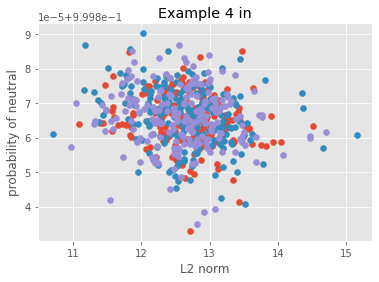

['pants', 'red', 'hair', 'walking', 'blue'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['pants', 'red', 'hair', 'walking', 'blue'] 



100%|██████████| 200/200 [00:35<00:00,  5.64it/s]


['pants', 'red', 'hair', 'walking', 'blue'] 



100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


| Min: 0.013489184739161806
Token: blue | attention: 0.025530176695244287
Token: red | attention: 0.025425196425178813
Token: pants | attention: 0.024904083344968003
Token: hair | attention: 0.024489728283553745
Token: walking | attention: 0.024383389722881215


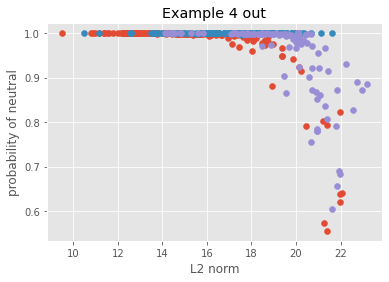





###### Example : 1 label neutral ########
['standing', 'person', 'next', 'dark', '.'] 



100%|██████████| 200/200 [00:36<00:00,  5.55it/s]


['standing', 'person', 'next', 'dark', '.'] 



100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


['standing', 'person', 'next', 'dark', '.'] 



100%|██████████| 200/200 [00:35<00:00,  5.61it/s]


| Min: 0.041817830779350404
Token: person | attention: 0.049255611322173466
Token: . | attention: 0.0454375803395911
Token: next | attention: 0.044404640703527586
Token: standing | attention: 0.043431880326890694
Token: dark | attention: 0.041445506556837944


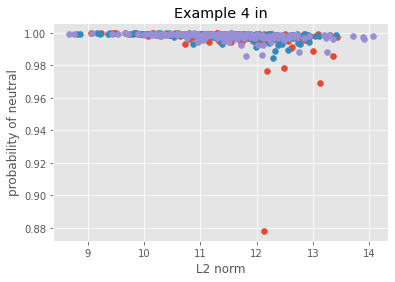

['old', 'building', 'standing', 'an', 'to'] 



100%|██████████| 200/200 [00:33<00:00,  5.89it/s]


['old', 'building', 'standing', 'an', 'to'] 



100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


['old', 'building', 'standing', 'an', 'to'] 



100%|██████████| 200/200 [00:17<00:00, 11.43it/s]


| Min: 0.02619517383198588
Token: an | attention: 0.04678919513589645
Token: to | attention: 0.04678017226522946
Token: old | attention: 0.046204325872211134
Token: building | attention: 0.04480907434266996
Token: standing | attention: 0.04461760001929597


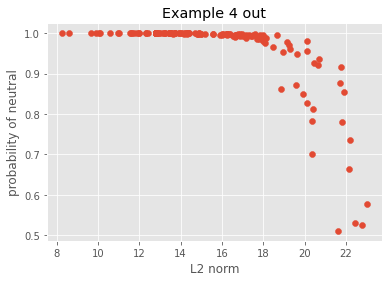





###### Example : 2 label neutral ########
['table', 'poet', 'reads', 'sitting', 'hire'] 



100%|██████████| 200/200 [00:34<00:00,  5.72it/s]


['table', 'poet', 'reads', 'sitting', 'hire'] 



100%|██████████| 200/200 [00:35<00:00,  5.68it/s]


['table', 'poet', 'reads', 'sitting', 'hire'] 



100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


| Min: 0.027708021334249183
Token: reads | attention: 0.047901869701843174
Token: poet | attention: 0.041779313342950784
Token: sitting | attention: 0.037463331665702475
Token: table | attention: 0.03528460194552069
Token: hire | attention: 0.0351245920618526


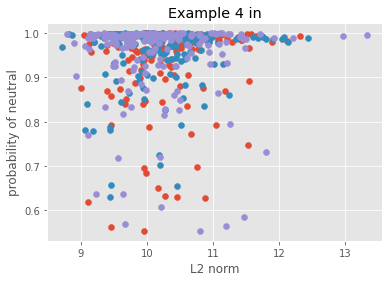

['sitting', 'k', 'sign', 'reads', 'table'] 



100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


['sitting', 'k', 'sign', 'reads', 'table'] 



100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


['sitting', 'k', 'sign', 'reads', 'table'] 



100%|██████████| 200/200 [00:17<00:00, 11.38it/s]


| Min: 0.01857598616766608
Token: table | attention: 0.03346037891277252
Token: sitting | attention: 0.032712653250794366
Token: k | attention: 0.03240909948791821
Token: sign | attention: 0.03238074132398786
Token: reads | attention: 0.03224832936391165


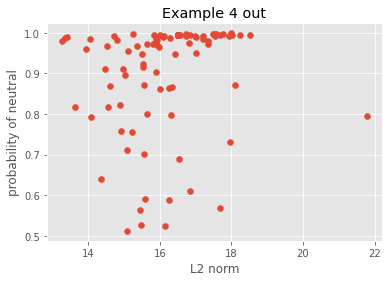

<Figure size 432x288 with 0 Axes>

In [61]:

mask_out_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label entailment ########
['skirt', 'blue', 'dress', '.', 'girl'] 



100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


['skirt', 'blue', 'dress', '.', 'girl'] 



100%|██████████| 200/200 [00:28<00:00,  6.98it/s]


['skirt', 'blue', 'dress', '.', 'girl'] 



100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


| Min: 0.028112016976491735
Token: dress | attention: 0.04029989677507431
Token: blue | attention: 0.03899692483636668
Token: skirt | attention: 0.03697590073911664
Token: girl | attention: 0.036613856011277646
Token: . | attention: 0.03448917484895453


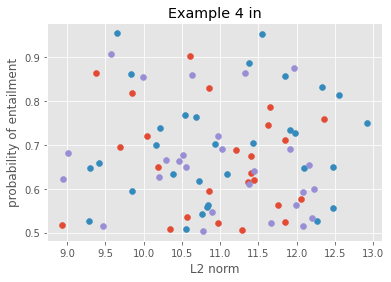

['blue', '##sies', 'black', 'water', 'dress'] 



100%|██████████| 200/200 [00:27<00:00,  7.36it/s]


['blue', '##sies', 'black', 'water', 'dress'] 



100%|██████████| 200/200 [00:17<00:00, 11.49it/s]


['blue', '##sies', 'black', 'water', 'dress'] 



100%|██████████| 200/200 [00:17<00:00, 11.35it/s]


| Min: 0.018394035360726466
Token: black | attention: 0.03543843034586561
Token: blue | attention: 0.034688028397074695
Token: water | attention: 0.033446659024873156
Token: dress | attention: 0.03341740964440207
Token: ##sies | attention: 0.03296549216388531


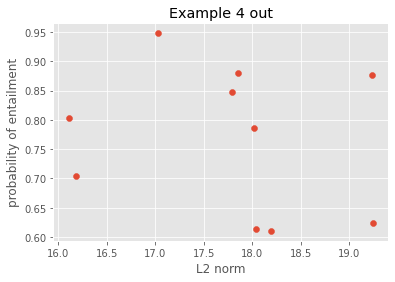





###### Example : 1 label entailment ########
['.', 'performed', 'performing', 'front', 'man'] 



100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


['.', 'performed', 'performing', 'front', 'man'] 



100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


['.', 'performed', 'performing', 'front', 'man'] 



100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


| Min: 0.031242701727613686
Token: performed | attention: 0.041876443385575446
Token: performing | attention: 0.04181603629199857
Token: . | attention: 0.03854041937317236
Token: man | attention: 0.038025681026177954
Token: front | attention: 0.03620002221770733


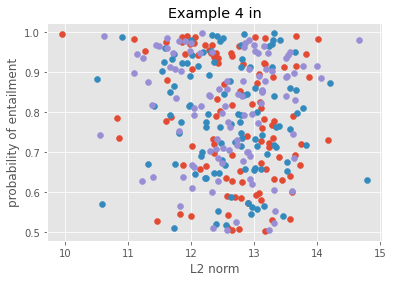

['his', 'house', 'is', 'performing', 'group'] 



100%|██████████| 200/200 [00:32<00:00,  6.16it/s]


['his', 'house', 'is', 'performing', 'group'] 



100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


['his', 'house', 'is', 'performing', 'group'] 



100%|██████████| 200/200 [00:16<00:00, 11.97it/s]


| Min: 0.023108136297850523
Token: performing | attention: 0.03619860882101464
Token: is | attention: 0.03618649656799103
Token: group | attention: 0.03597293061017291
Token: his | attention: 0.03545854958530704
Token: house | attention: 0.03538691155385712


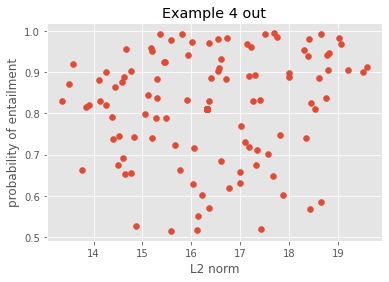





###### Example : 2 label entailment ########
['charity', 'race', 'races', '##track', 'racing'] 



100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


['charity', 'race', 'races', '##track', 'racing'] 



100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


['charity', 'race', 'races', '##track', 'racing'] 



100%|██████████| 200/200 [00:30<00:00,  6.65it/s]


| Min: 0.02828270536506893
Token: charity | attention: 0.04511473158412016
Token: races | attention: 0.04081206289133118
Token: racing | attention: 0.04027631981146554
Token: race | attention: 0.03733529375207043
Token: ##track | attention: 0.03705865193847403


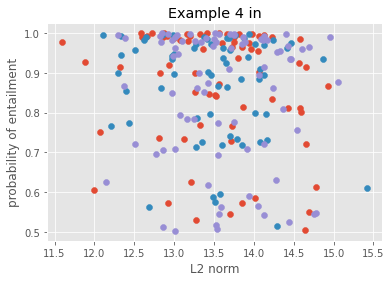

['event', 'wheel', 'races', 'race', 'charity'] 



100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


['event', 'wheel', 'races', 'race', 'charity'] 



100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


['event', 'wheel', 'races', 'race', 'charity'] 



100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


| Min: 0.018671749884033313
Token: race | attention: 0.03915114559024026
Token: wheel | attention: 0.03817373592248078
Token: event | attention: 0.03759956484416414
Token: races | attention: 0.03664787656794796
Token: charity | attention: 0.03659253482545283


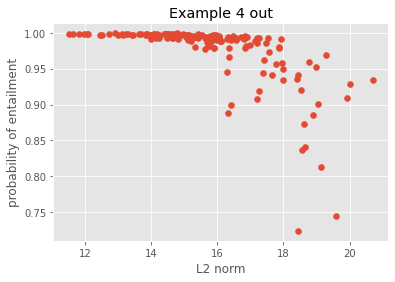

<Figure size 432x288 with 0 Axes>

In [62]:
mask_out_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label contradiction ########
['shirt', 'shove', '##bar', 'wheel', 'skiing'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


['shirt', 'shove', '##bar', 'wheel', 'skiing'] 



100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


['shirt', 'shove', '##bar', 'wheel', 'skiing'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


| Min: 0.024114465874746197
Token: shirt | attention: 0.0371223542604301
Token: shove | attention: 0.031304672384754956
Token: wheel | attention: 0.03104914727005246
Token: skiing | attention: 0.03005668541869224
Token: ##bar | attention: 0.029909734529255286


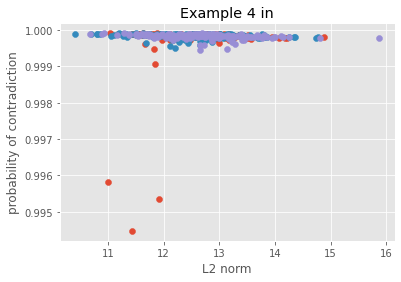

['##row', 'wheel', 'he', 'outside', 'works'] 



100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


['##row', 'wheel', 'he', 'outside', 'works'] 



100%|██████████| 200/200 [00:16<00:00, 11.95it/s]


['##row', 'wheel', 'he', 'outside', 'works'] 



100%|██████████| 200/200 [00:16<00:00, 11.90it/s]


| Min: 0.017137062838001545
Token: works | attention: 0.03147044516718285
Token: wheel | attention: 0.030734774079369278
Token: ##row | attention: 0.02992618643327691
Token: he | attention: 0.029517362397802935
Token: outside | attention: 0.02919407807507972


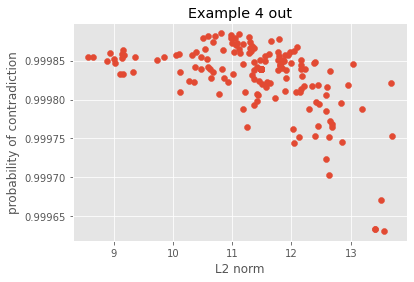





###### Example : 1 label contradiction ########
['wearing', 'shirt', 'pants', 'hunched', 'person'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


['wearing', 'shirt', 'pants', 'hunched', 'person'] 



100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


['wearing', 'shirt', 'pants', 'hunched', 'person'] 



100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


| Min: 0.0361992929546036
Token: hunched | attention: 0.0590114901889012
Token: pants | attention: 0.04545838432458975
Token: shirt | attention: 0.044951777216269063
Token: wearing | attention: 0.041037324385628425
Token: person | attention: 0.04023968466438964


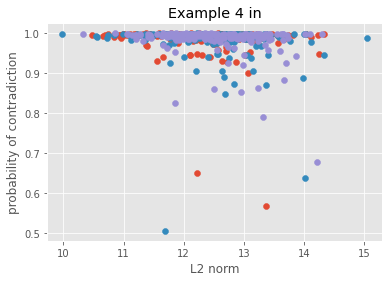

['is', 'over', 'red', 'green', 'black'] 



100%|██████████| 200/200 [00:34<00:00,  5.88it/s]


['is', 'over', 'red', 'green', 'black'] 



100%|██████████| 200/200 [00:16<00:00, 12.03it/s]


['is', 'over', 'red', 'green', 'black'] 



100%|██████████| 200/200 [00:16<00:00, 12.01it/s]


| Min: 0.02366775167798975
Token: black | attention: 0.04342743868217461
Token: green | attention: 0.04105441417302954
Token: over | attention: 0.04047395524676288
Token: is | attention: 0.0402745244931973
Token: red | attention: 0.0401531314211477


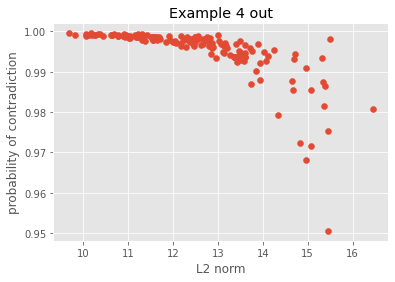





###### Example : 2 label contradiction ########
['awe', 'pink', 'plastic', 'kids', 'listened'] 



100%|██████████| 200/200 [00:27<00:00,  7.33it/s]


['awe', 'pink', 'plastic', 'kids', 'listened'] 



100%|██████████| 200/200 [00:26<00:00,  7.41it/s]


['awe', 'pink', 'plastic', 'kids', 'listened'] 



100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


| Min: 0.02050571099209724
Token: kids | attention: 0.032862735588664045
Token: listened | attention: 0.03175857188347556
Token: awe | attention: 0.030549028442839847
Token: plastic | attention: 0.02976241437245165
Token: pink | attention: 0.029149550359909803


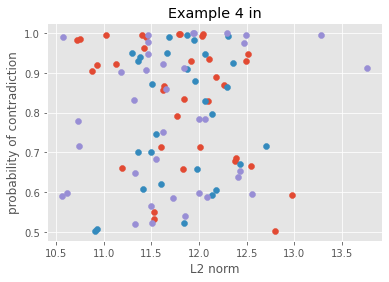

['pink', 'straw', 'plastic', 'cup', 'p'] 



100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


['pink', 'straw', 'plastic', 'cup', 'p'] 



100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


['pink', 'straw', 'plastic', 'cup', 'p'] 



100%|██████████| 200/200 [00:16<00:00, 11.91it/s]


| Min: 0.015902644813494248
Token: plastic | attention: 0.02600769739353389
Token: pink | attention: 0.02556100017430463
Token: cup | attention: 0.025533323567630977
Token: p | attention: 0.02547142720325489
Token: straw | attention: 0.02528938826509314


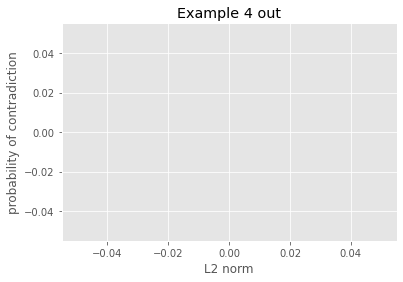

<Figure size 432x288 with 0 Axes>

In [63]:
mask_out_top5(text[2], "contradiction", 2, "L2",)





###### Example : 0 label neutral ########
['blond', 'pants', 'shirt', 'hair', 'jeans'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


['blond', 'pants', 'shirt', 'hair', 'jeans'] 



100%|██████████| 200/200 [00:34<00:00,  5.84it/s]


['blond', 'pants', 'shirt', 'hair', 'jeans'] 



100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


| Min: 0.01860018755453984
Token: shirt | attention: 0.030498650969055772
Token: pants | attention: 0.029334440362541778
Token: blond | attention: 0.028585310086865604
Token: jeans | attention: 0.02785972543073312
Token: hair | attention: 0.027421020888217008


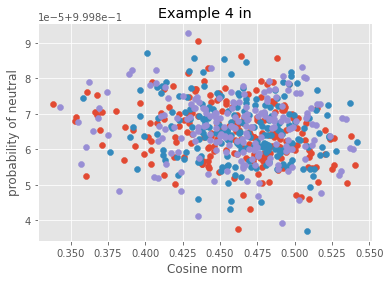

['red', 'hair', 'blue', 'pants', 'walking'] 



100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


['red', 'hair', 'blue', 'pants', 'walking'] 



100%|██████████| 200/200 [00:33<00:00,  5.88it/s]


['red', 'hair', 'blue', 'pants', 'walking'] 



100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


| Min: 0.013489184739161806
Token: blue | attention: 0.025530176695244287
Token: red | attention: 0.025425196425178813
Token: pants | attention: 0.024904083344968003
Token: hair | attention: 0.024489728283553745
Token: walking | attention: 0.024383389722881215


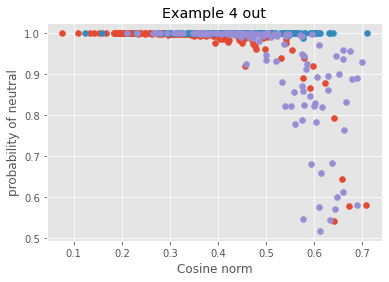





###### Example : 1 label neutral ########
['.', 'dark', 'person', 'standing', 'next'] 



100%|██████████| 200/200 [00:34<00:00,  5.83it/s]


['.', 'dark', 'person', 'standing', 'next'] 



100%|██████████| 200/200 [00:34<00:00,  5.83it/s]


['.', 'dark', 'person', 'standing', 'next'] 



100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


| Min: 0.041817830779350404
Token: person | attention: 0.049255611322173466
Token: . | attention: 0.0454375803395911
Token: next | attention: 0.044404640703527586
Token: standing | attention: 0.043431880326890694
Token: dark | attention: 0.041445506556837944


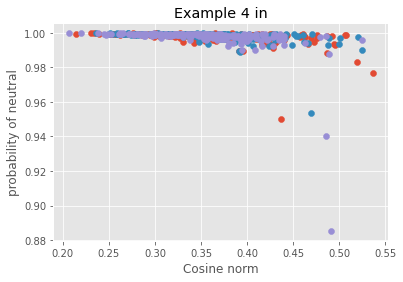

['to', 'an', 'building', 'standing', 'old'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['to', 'an', 'building', 'standing', 'old'] 



100%|██████████| 200/200 [00:26<00:00,  7.48it/s]


['to', 'an', 'building', 'standing', 'old'] 



100%|██████████| 200/200 [00:24<00:00,  8.23it/s]


| Min: 0.02619517383198588
Token: an | attention: 0.04678919513589645
Token: to | attention: 0.04678017226522946
Token: old | attention: 0.046204325872211134
Token: building | attention: 0.04480907434266996
Token: standing | attention: 0.04461760001929597


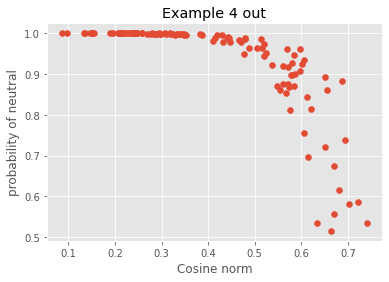





###### Example : 2 label neutral ########
['hire', 'reads', 'table', 'poet', 'sitting'] 



100%|██████████| 200/200 [00:34<00:00,  5.88it/s]


['hire', 'reads', 'table', 'poet', 'sitting'] 



100%|██████████| 200/200 [00:34<00:00,  5.86it/s]


['hire', 'reads', 'table', 'poet', 'sitting'] 



100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


| Min: 0.027708021334249183
Token: reads | attention: 0.047901869701843174
Token: poet | attention: 0.041779313342950784
Token: sitting | attention: 0.037463331665702475
Token: table | attention: 0.03528460194552069
Token: hire | attention: 0.0351245920618526


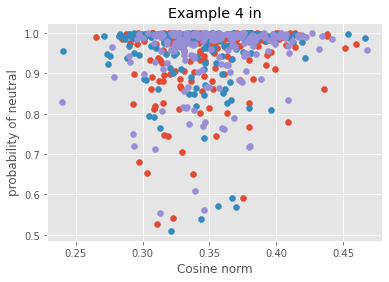

['sign', 'k', 'sitting', 'reads', 'table'] 



100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


['sign', 'k', 'sitting', 'reads', 'table'] 



100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


['sign', 'k', 'sitting', 'reads', 'table'] 



100%|██████████| 200/200 [00:17<00:00, 11.74it/s]


| Min: 0.01857598616766608
Token: table | attention: 0.03346037891277252
Token: sitting | attention: 0.032712653250794366
Token: k | attention: 0.03240909948791821
Token: sign | attention: 0.03238074132398786
Token: reads | attention: 0.03224832936391165


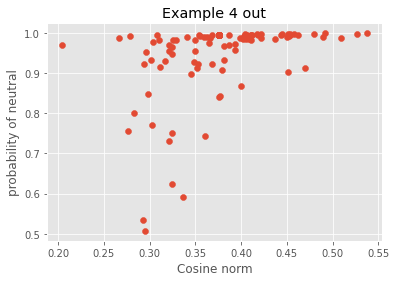

<Figure size 432x288 with 0 Axes>

In [64]:
mask_out_top5(text[0], "neutral", 0, "Cosine")





###### Example : 0 label entailment ########
['.', 'blue', 'skirt', 'dress', 'girl'] 



100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


['.', 'blue', 'skirt', 'dress', 'girl'] 



100%|██████████| 200/200 [00:27<00:00,  7.36it/s]


['.', 'blue', 'skirt', 'dress', 'girl'] 



100%|██████████| 200/200 [00:27<00:00,  7.30it/s]


| Min: 0.028112016976491735
Token: dress | attention: 0.04029989677507431
Token: blue | attention: 0.03899692483636668
Token: skirt | attention: 0.03697590073911664
Token: girl | attention: 0.036613856011277646
Token: . | attention: 0.03448917484895453


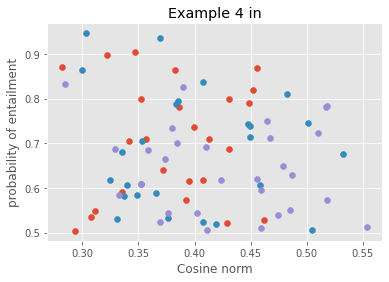

['blue', 'dress', 'water', '##sies', 'black'] 



100%|██████████| 200/200 [00:26<00:00,  7.53it/s]


['blue', 'dress', 'water', '##sies', 'black'] 



100%|██████████| 200/200 [00:16<00:00, 11.79it/s]


['blue', 'dress', 'water', '##sies', 'black'] 



100%|██████████| 200/200 [00:16<00:00, 11.84it/s]


| Min: 0.018394035360726466
Token: black | attention: 0.03543843034586561
Token: blue | attention: 0.034688028397074695
Token: water | attention: 0.033446659024873156
Token: dress | attention: 0.03341740964440207
Token: ##sies | attention: 0.03296549216388531


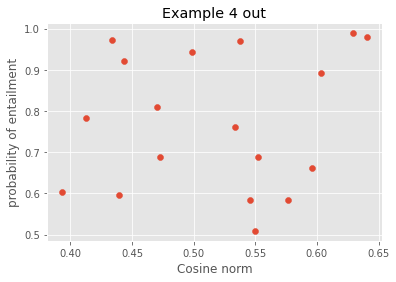





###### Example : 1 label entailment ########
['.', 'man', 'front', 'performed', 'performing'] 



100%|██████████| 200/200 [00:30<00:00,  6.57it/s]


['.', 'man', 'front', 'performed', 'performing'] 



100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


['.', 'man', 'front', 'performed', 'performing'] 



100%|██████████| 200/200 [00:30<00:00,  6.47it/s]


| Min: 0.031242701727613686
Token: performed | attention: 0.041876443385575446
Token: performing | attention: 0.04181603629199857
Token: . | attention: 0.03854041937317236
Token: man | attention: 0.038025681026177954
Token: front | attention: 0.03620002221770733


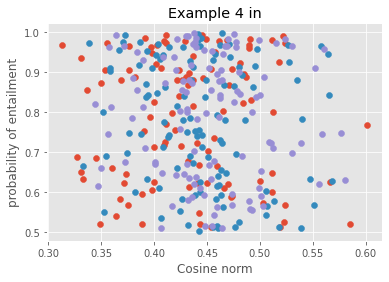

['group', 'his', 'performing', 'house', 'is'] 



100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


['group', 'his', 'performing', 'house', 'is'] 



100%|██████████| 200/200 [00:16<00:00, 11.78it/s]


['group', 'his', 'performing', 'house', 'is'] 



100%|██████████| 200/200 [00:16<00:00, 11.87it/s]


| Min: 0.023108136297850523
Token: performing | attention: 0.03619860882101464
Token: is | attention: 0.03618649656799103
Token: group | attention: 0.03597293061017291
Token: his | attention: 0.03545854958530704
Token: house | attention: 0.03538691155385712


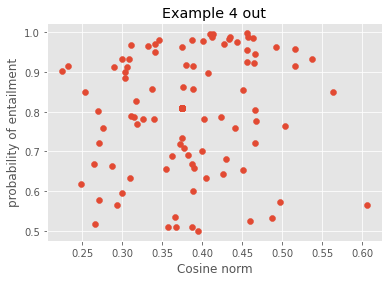





###### Example : 2 label entailment ########
['race', 'racing', 'races', 'charity', '##track'] 



100%|██████████| 200/200 [00:29<00:00,  6.75it/s]


['race', 'racing', 'races', 'charity', '##track'] 



100%|██████████| 200/200 [00:29<00:00,  6.81it/s]


['race', 'racing', 'races', 'charity', '##track'] 



100%|██████████| 200/200 [00:29<00:00,  6.81it/s]


| Min: 0.02828270536506893
Token: charity | attention: 0.04511473158412016
Token: races | attention: 0.04081206289133118
Token: racing | attention: 0.04027631981146554
Token: race | attention: 0.03733529375207043
Token: ##track | attention: 0.03705865193847403


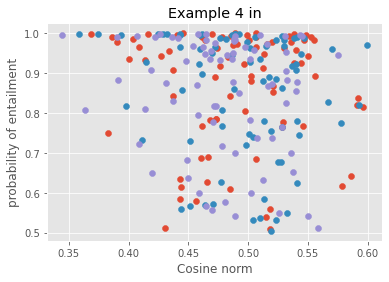

['event', 'races', 'race', 'charity', 'wheel'] 



100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


['event', 'races', 'race', 'charity', 'wheel'] 



100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


['event', 'races', 'race', 'charity', 'wheel'] 



100%|██████████| 200/200 [00:17<00:00, 11.75it/s]


| Min: 0.018671749884033313
Token: race | attention: 0.03915114559024026
Token: wheel | attention: 0.03817373592248078
Token: event | attention: 0.03759956484416414
Token: races | attention: 0.03664787656794796
Token: charity | attention: 0.03659253482545283


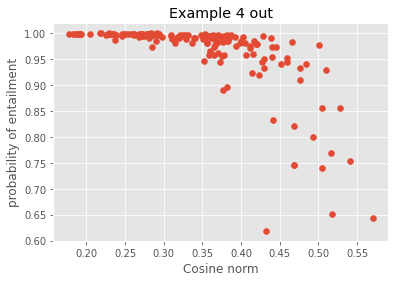

<Figure size 432x288 with 0 Axes>

In [65]:
mask_out_top5(text[1], "entailment", 1, "Cosine",)





###### Example : 0 label contradiction ########
['##bar', 'skiing', 'shove', 'shirt', 'wheel'] 



100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


['##bar', 'skiing', 'shove', 'shirt', 'wheel'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


['##bar', 'skiing', 'shove', 'shirt', 'wheel'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


| Min: 0.024114465874746197
Token: shirt | attention: 0.0371223542604301
Token: shove | attention: 0.031304672384754956
Token: wheel | attention: 0.03104914727005246
Token: skiing | attention: 0.03005668541869224
Token: ##bar | attention: 0.029909734529255286


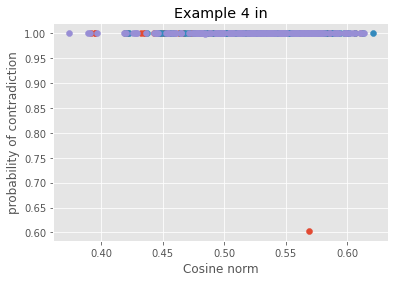

['outside', 'wheel', 'works', 'he', '##row'] 



100%|██████████| 200/200 [00:35<00:00,  5.65it/s]


['outside', 'wheel', 'works', 'he', '##row'] 



100%|██████████| 200/200 [00:17<00:00, 11.65it/s]


['outside', 'wheel', 'works', 'he', '##row'] 



100%|██████████| 200/200 [00:17<00:00, 11.57it/s]


| Min: 0.017137062838001545
Token: works | attention: 0.03147044516718285
Token: wheel | attention: 0.030734774079369278
Token: ##row | attention: 0.02992618643327691
Token: he | attention: 0.029517362397802935
Token: outside | attention: 0.02919407807507972


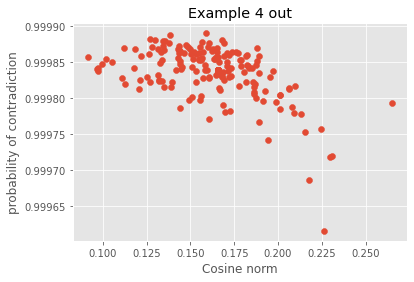





###### Example : 1 label contradiction ########
['person', 'shirt', 'hunched', 'pants', 'wearing'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['person', 'shirt', 'hunched', 'pants', 'wearing'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['person', 'shirt', 'hunched', 'pants', 'wearing'] 



100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


| Min: 0.0361992929546036
Token: hunched | attention: 0.0590114901889012
Token: pants | attention: 0.04545838432458975
Token: shirt | attention: 0.044951777216269063
Token: wearing | attention: 0.041037324385628425
Token: person | attention: 0.04023968466438964


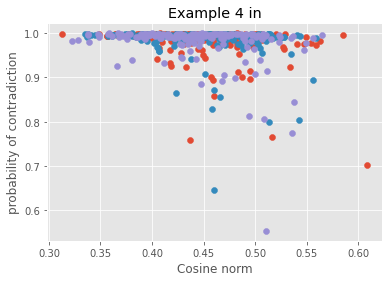

['black', 'over', 'is', 'red', 'green'] 



100%|██████████| 200/200 [00:34<00:00,  5.83it/s]


['black', 'over', 'is', 'red', 'green'] 



100%|██████████| 200/200 [00:16<00:00, 11.92it/s]


['black', 'over', 'is', 'red', 'green'] 



100%|██████████| 200/200 [00:16<00:00, 11.86it/s]


| Min: 0.02366775167798975
Token: black | attention: 0.04342743868217461
Token: green | attention: 0.04105441417302954
Token: over | attention: 0.04047395524676288
Token: is | attention: 0.0402745244931973
Token: red | attention: 0.0401531314211477


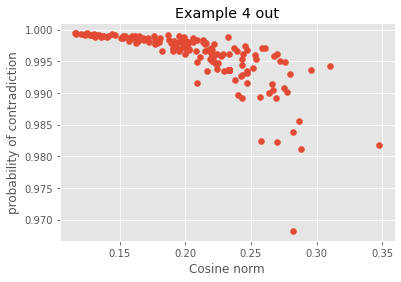





###### Example : 2 label contradiction ########
['pink', 'kids', 'awe', 'listened', 'plastic'] 



100%|██████████| 200/200 [00:27<00:00,  7.32it/s]


['pink', 'kids', 'awe', 'listened', 'plastic'] 



100%|██████████| 200/200 [00:27<00:00,  7.37it/s]


['pink', 'kids', 'awe', 'listened', 'plastic'] 



100%|██████████| 200/200 [00:27<00:00,  7.20it/s]


| Min: 0.02050571099209724
Token: kids | attention: 0.032862735588664045
Token: listened | attention: 0.03175857188347556
Token: awe | attention: 0.030549028442839847
Token: plastic | attention: 0.02976241437245165
Token: pink | attention: 0.029149550359909803


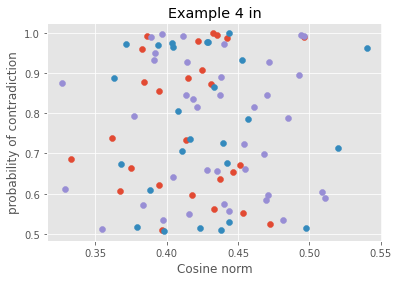

['p', 'plastic', 'cup', 'pink', 'straw'] 



100%|██████████| 200/200 [00:26<00:00,  7.68it/s]


['p', 'plastic', 'cup', 'pink', 'straw'] 



100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


['p', 'plastic', 'cup', 'pink', 'straw'] 



100%|██████████| 200/200 [00:16<00:00, 11.89it/s]


| Min: 0.015902644813494248
Token: plastic | attention: 0.02600769739353389
Token: pink | attention: 0.02556100017430463
Token: cup | attention: 0.025533323567630977
Token: p | attention: 0.02547142720325489
Token: straw | attention: 0.02528938826509314


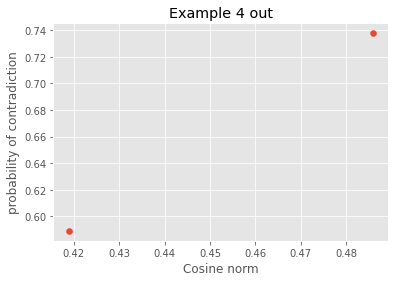

<Figure size 432x288 with 0 Axes>

In [66]:
mask_out_top5(text[2], "contradiction", 2, "Cosine",)

In [67]:
select_max_imp = 100

In [68]:
def calculate_imp(true_logits, true_class, perturbed_logits, perturbed_class):
  if(perturbed_class == true_class):
    return true_logits[true_class] - perturbed_logits[true_class]
  return true_logits[true_class] - perturbed_logits[true_class] + true_logits[perturbed_class] - perturbed_logits[perturbed_class]

In [69]:
print(tokenizer.decode([1532]))

form


In [70]:
def intersection(a, b):
  cnt = 0;
  print(a)
  print(b)
  for i in range(min(len(a), len(b))):
      if(a[i] == b[i]):
          cnt += 1;
      
  return (cnt/min(len(a), len(b)))*100

In [71]:
def find_intersection_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)
        logits = predict_proba(tokenized_threads)
        class_assigned = torch.argmax(logits[0, :])
        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min = find_topk_tokens(graph, select_max_imp)
        arr = tokenized_threads.cpu().detach().clone().numpy()

        candidates = []
        for j in range(len(tokens)):
          temp_tokenized_threads = np.concatenate([arr[0, : j], arr[0, j + 1:], np.array([tokenizer.pad_token_id])])
    
          temp_logits = predict_proba(torch.tensor(temp_tokenized_threads, device=device).reshape((1, len(temp_tokenized_threads))))

          temp_class_assigned = torch.argmax(temp_logits)

          importance_score = calculate_imp(logits[0], class_assigned, temp_logits[0], temp_class_assigned)
          candidates.append((arr[0, j], importance_score))
        candidates.sort(key = lambda x : x[1])
        candidates.reverse()
        print(candidates)
        print("intersection between in : ", intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]", "[SEP]"]], [rev_mapping_ind[z] for z in topk_in]))
        print("intersection between out : ",intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]","[SEP]"]], [rev_mapping_ind[z] for z in topk_out]))

In [72]:

find_intersection_top5(text[2], "contradiction", 2, "Cosine",)





###### Example : 0 label contradiction ########
[(1590, tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)), (119, tensor(4.4227e-05, device='cuda:0', grad_fn=<SubBackward0>)), (14106, tensor(4.3631e-05, device='cuda:0', grad_fn=<SubBackward0>)), (3351, tensor(3.2783e-05, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(1.5438e-05, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(1.5438e-05, device='cuda:0', grad_fn=<SubBackward0>)), (102, tensor(1.3530e-05, device='cuda:0', grad_fn=<SubBackward0>)), (138, tensor(9.2983e-06, device='cuda:0', grad_fn=<SubBackward0>)), (1299, tensor(7.8082e-06, device='cuda:0', grad_fn=<SubBackward0>)), (2969, tensor(7.4506e-06, device='cuda:0', grad_fn=<SubBackward0>)), (119, tensor(5.9009e-06, device='cuda:0', grad_fn=<SubBackward0>)), (9219, tensor(4.8876e-06, device='cuda:0', grad_fn=<SubBackward0>)), (1110, tensor(4.4703e-06, device='cuda:0', grad_fn=<SubBackward0>)), (4883, tensor(3.5167e-06, device='cuda:0', grad_fn=<SubBack

In [73]:
find_intersection_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label entailment ########
[(1105, tensor(0.1795, device='cuda:0', grad_fn=<SubBackward0>)), (9606, tensor(0.1724, device='cuda:0', grad_fn=<SubBackward0>)), (1602, tensor(0.1645, device='cuda:0', grad_fn=<SubBackward0>)), (2221, tensor(0.1022, device='cuda:0', grad_fn=<SubBackward0>)), (1110, tensor(0.0862, device='cuda:0', grad_fn=<SubBackward0>)), (119, tensor(0.0768, device='cuda:0', grad_fn=<SubBackward0>)), (119, tensor(0.0678, device='cuda:0', grad_fn=<SubBackward0>)), (1158, tensor(0.0208, device='cuda:0', grad_fn=<SubBackward0>)), (1873, tensor(0.0108, device='cuda:0', grad_fn=<SubBackward0>)), (26868, tensor(0.0042, device='cuda:0', grad_fn=<SubBackward0>)), (1109, tensor(0.0014, device='cuda:0', grad_fn=<SubBackward0>)), (5358, tensor(0.0013, device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(0., device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(0., device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(0., device='cuda:0', grad_fn=<SubBackward0>)

In [74]:
find_intersection_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label neutral ########
[(102, tensor(0.0002, device='cuda:0', grad_fn=<SubBackward0>)), (3179, tensor(0.0002, device='cuda:0', grad_fn=<SubBackward0>)), (119, tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)), (1960, tensor(4.1068e-05, device='cuda:0', grad_fn=<SubBackward0>)), (1132, tensor(3.4273e-05, device='cuda:0', grad_fn=<SubBackward0>)), (1796, tensor(3.4034e-05, device='cuda:0', grad_fn=<SubBackward0>)), (3179, tensor(2.9087e-05, device='cuda:0', grad_fn=<SubBackward0>)), (102, tensor(8.9407e-06, device='cuda:0', grad_fn=<SubBackward0>)), (102, tensor(8.9407e-06, device='cuda:0', grad_fn=<SubBackward0>)), (8781, tensor(8.2850e-06, device='cuda:0', grad_fn=<SubBackward0>)), (12447, tensor(7.2718e-06, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(5.8413e-06, device='cuda:0', grad_fn=<SubBackward0>)), (101, tensor(5.8413e-06, device='cuda:0', grad_fn=<SubBackward0>)), (1234, tensor(4.1723e-06, device='cuda:0', grad_fn=<SubBackward0>)), (110

In [ ]:
def remove_padding(x):
    ret = []
    for i in x[::-1]:
        if(i == "[PAD]"):
            continue
        else:
            ret.append(i)
    ret = ret[::-1]
    return ret

In [ ]:
for i, sent in enumerate(text):
    text[i] = remove_padding(sent)


In [ ]:
color = ["\033[1;31;47m", "\033[1;32;47m", "\033[1;33;47m", 
         "\033[1;34;47m", "\033[1;35;47m", "\033[1;36;47m",
         "\033[1;37;47m"]
mapping = ["Red", "Green", "Yellow", "Blue", "Purple", "Cyan", "White"]


In [ ]:
print("\033[1;32;47m" + text[0][0])

In [ ]:
reverse_mapping = {}
for i in mapping_ind:
    reverse_mapping[mapping_ind[i]] = i

In [ ]:
tokens = []
for lay in range(12):
    for i in graph_attention[lay]:
        l = 0
        for j in graph_attention[lay][i]:
            l += graph_attention[lay][i][j][0]
        l /= len(graph_attention[lay][i])
        tokens.append((l, reverse_mapping[i]))


In [ ]:
tokens_high_deg = []
for lay in range(12):
    for i in graph_attention[lay]:
        tokens_high_deg.append((len(graph_attention[lay][i]), reverse_mapping[i]))

In [ ]:
tokens.sort(reverse = True)
tokens_high_deg.sort(reverse = True)

In [ ]:
print(tokens[:10])
print(tokens_high_deg[:10])

In [ ]:
factor = 40
factor_2 = 20

In [ ]:
Truetop_tok = [i[1] for i in tokens[:len(mapping)*factor]]
top_tok_deg = [i[1] for i in tokens_high_deg[:len(mapping)*factor_2]]


In [ ]:
def parse_top_k(l, length):
    ret = []
    ind = 0
    mapping_check = {}
    while(len(ret) != length and ind < len(l)):
        if(l[ind][1] in mapping_check):
            ind += 1
            continue
        mapping_check[l[ind][1]] = 1
        ret.append(l[ind][1])
        ind += 1
    return ret
top_tok = parse_top_k(tokens, len(mapping)*factor)

top_tok_deg = parse_top_k(tokens_high_deg, len(mapping)*factor_2)

In [ ]:
print("Attention")
print(top_tok)
print("Degree ")
print(top_tok_deg)

In [ ]:
print(len(top_tok_deg))

In [ ]:
print(set(top_tok))


In [ ]:
print(set(top_tok_deg))

In [ ]:
def masking_text(tok, text, color):
    for i in range(len(text)):
        print("\t ###################### Example " + str(i) + " ##############")
        print("")
        masked_text = []
        for j in text[i]:
            flag = 0
            for ind in range(len(tok)):
                if(j == tok[ind]):
                    masked_text.append(color[ind//factor] + j + "\x1b[0m")
                    flag = 1
                    break
            if(flag == 0):
                masked_text.append(j)
        print(" ".join(masked_text))   
        
        print("")

In [ ]:
print("\t ####### Mapping for high attention value \n \n")
for i in range(len(mapping)):
    print(color[i], mapping[i], " : ", top_tok[i*factor : (i + 1)*factor])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(attention value) priority top : ", str(i*factor), "-", str((i + 1)*factor))

In [ ]:
print(masking_text(top_tok, text, color))

In [ ]:
print("\t ####### Mapping for Degree value \n \n")
for i in range(len(mapping)):
    print(color[i] ,mapping[i], " : ", top_tok_deg[i*factor_2 : (i + 1)*factor_2])

In [ ]:
for i in range(len(mapping)):
    print(mapping[i], " : ", "(degree) priority top : ", str(i*factor), "-", str((i + 1)*factor_2))

In [ ]:
print(masking_text(top_tok_deg, text, color))

In [ ]:
print(set(i[1] for i in tokens[:100]))

In [ ]:
print(set(i[1] for i in tokens_high_deg[:200]))

In [ ]:
import matplotlib.pyplot as plt

def plot_degree_dist(degrees):
    plt.hist(degrees)
    plt.show()


In [ ]:
for lay in range(12):
    degree = []
    for i in graph_attention[lay]:
        degree.append(len(graph_attention[lay][i]))
    degree.sort(reverse = True)
    plot_degree_dist(degree)
    